This code is used to train a deep learning model on Bing Searches. The user can update what the code searches for by changing the searches list variable. After completing the Bing search, the user is shown some example images found before the model is trained. After training the model, the user can search for more images to test the model or they can import their own images.

## Setting things up...

In [1]:
# Checking kaggle is connected to the internet
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# Pip installing libraries - can ignore errors
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai icrawler
    
    # More pip for current numpy issues...
    !pip install numpy==1.26.5 --upgrade --force-reinstall
    !pip install scipy==1.10.1 --upgrade --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB

In [3]:
# Import necessary modules
from icrawler.builtin import BingImageCrawler
from fastai.vision.all import *
from pathlib import Path
import shutil
import matplotlib.pyplot as plt

## Importing images for the training

In [4]:
def search_images(image_name, num_images=20, show_n=5, max_size=400, root=Path('.'), offset=0):
    "Download images from Bing, remove failed ones, resize, and show examples"
    
    if num_images < show_n:
        show_n = num_images
        print(f'Showing {show_n} images')
    
    # Set up destination folder
    path = root/image_name
    
    # If folder exists, delete all contents
    if path.exists():
        print(f"Folder '{path}' exists. Deleting all contents...")
        shutil.rmtree(path)
    
    # Recreate the empty folder
    path.mkdir(parents=True, exist_ok=True)
    
    # Create a Bing image crawler
    crawler = BingImageCrawler(storage={'root_dir': path})
    
    # Crawl images automatically
    crawler.crawl(keyword=image_name, max_num=num_images, offset=offset)
    
    # List downloaded images
    images = get_image_files(path)
    print(f"Downloaded {len(images)} '{image_name}' images")
    
    # Remove any images that may have failed
    failed = verify_images(images)
    if len(failed) > 0:
        failed.map(Path.unlink)
        print(f"Removed {len(failed)} failed images")
    
    # Refresh the image list after cleanup
    images = get_image_files(path)
    
    # Display first few images
    if len(images) > 0 and show_n > 0:
        n = min(show_n, len(images))
        _, axs = plt.subplots(1, n, figsize=(n*3, 3))
        for i, ax in enumerate(axs):
            img = PILImage.create(images[i])
            ax.imshow(img)
            ax.axis('off')
        plt.show()
    
    # Resize all images in the folder
    resize_images(path, max_size=max_size, dest=path)

Folder 'dataset/kanji' exists. Deleting all contents...
Downloaded 30 'kanji' images


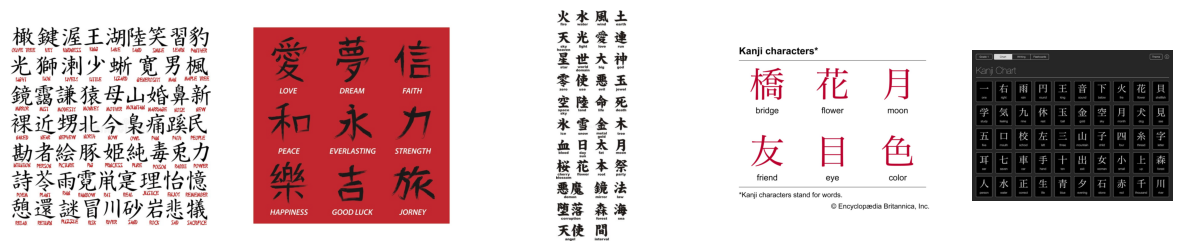

Downloaded 27 'hiragana' images


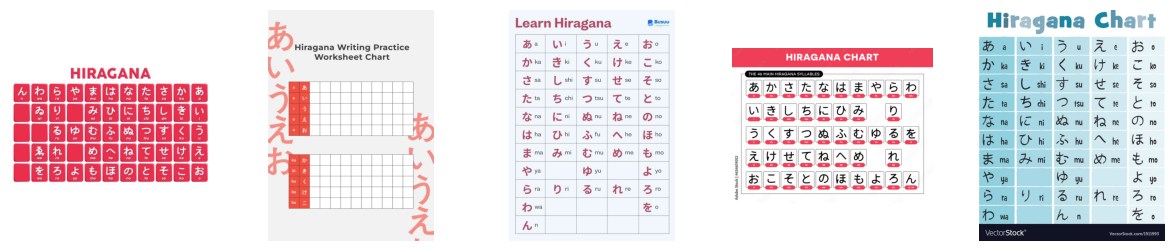

Downloaded 32 'katakana' images


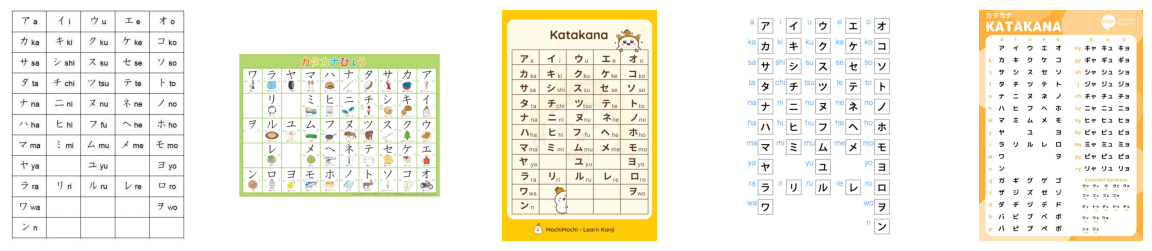

In [6]:
# Creating a folder for training data
training_root = Path('dataset')

# Create a list of what you want the AI to learn
searches = ['kanji', 'hiragana', 'katakana']

# Choose number of images to train on
no_images = 50

# Create folders with photos of items
for search in searches:
    search_images(search, num_images = no_images, show_n = 5, root = training_root)

## Training the model

In item_tfms, there are many ways of transforming images so that they are all standard sizes e.g. crop, squish, pad.

Batch tfms are changed every epoch so that the model sees different parts of the images.


Training on the following folders: ['kanji', 'hiragana', 'katakana']


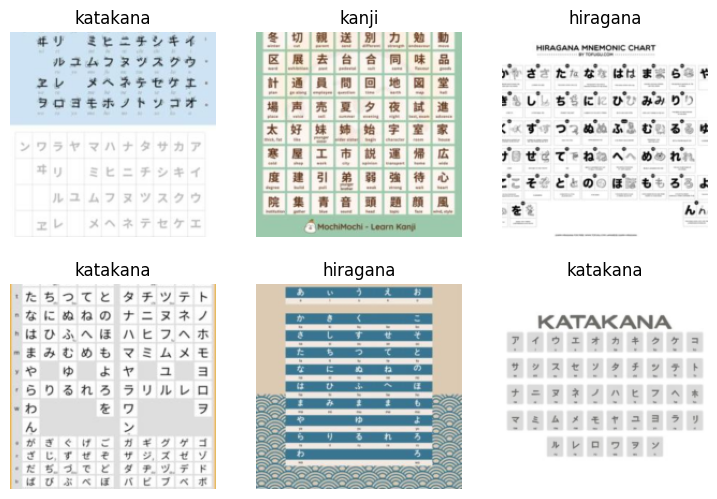

In [7]:
# Get all image files from the root, but only from selected folders
items = [f for f in get_image_files(training_root) if f.parent.name in searches]
print(f"Training on the following folders: {searches}")

# Create data block which will be input to train the model
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Input: Image, Output: Category
    get_items=lambda _: items,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Testing, train with 80%
    get_y=parent_label, # Another function, returns parent folder
    item_tfms=[Resize(192, method='Crop')] # Transform each item to be the same size
).dataloaders(source=None, bs=32)

dls.show_batch(max_n=6) # shows an example of what is passed into the model

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate) # Train the model on the data block, using model resnet18
learn.fine_tune(3) # epochs = 3

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s] 


## Cleaning the Data Set

It is better to clean the data set (remove and change images to help the model become more accurate), after the model has been trained. This is so it will show you the images it is most confused about - these will probably be the ones which are wrong

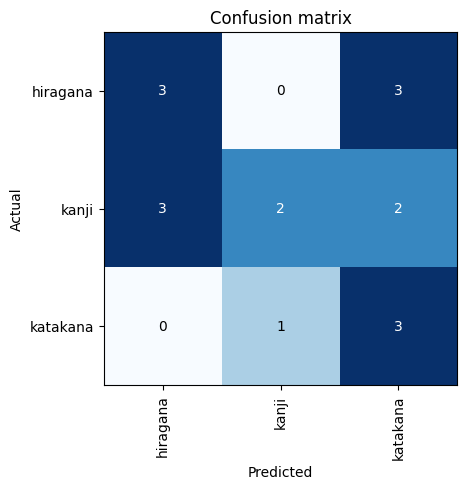

In [9]:
# Generates a matrix to show which guesses were right and which were wrong
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

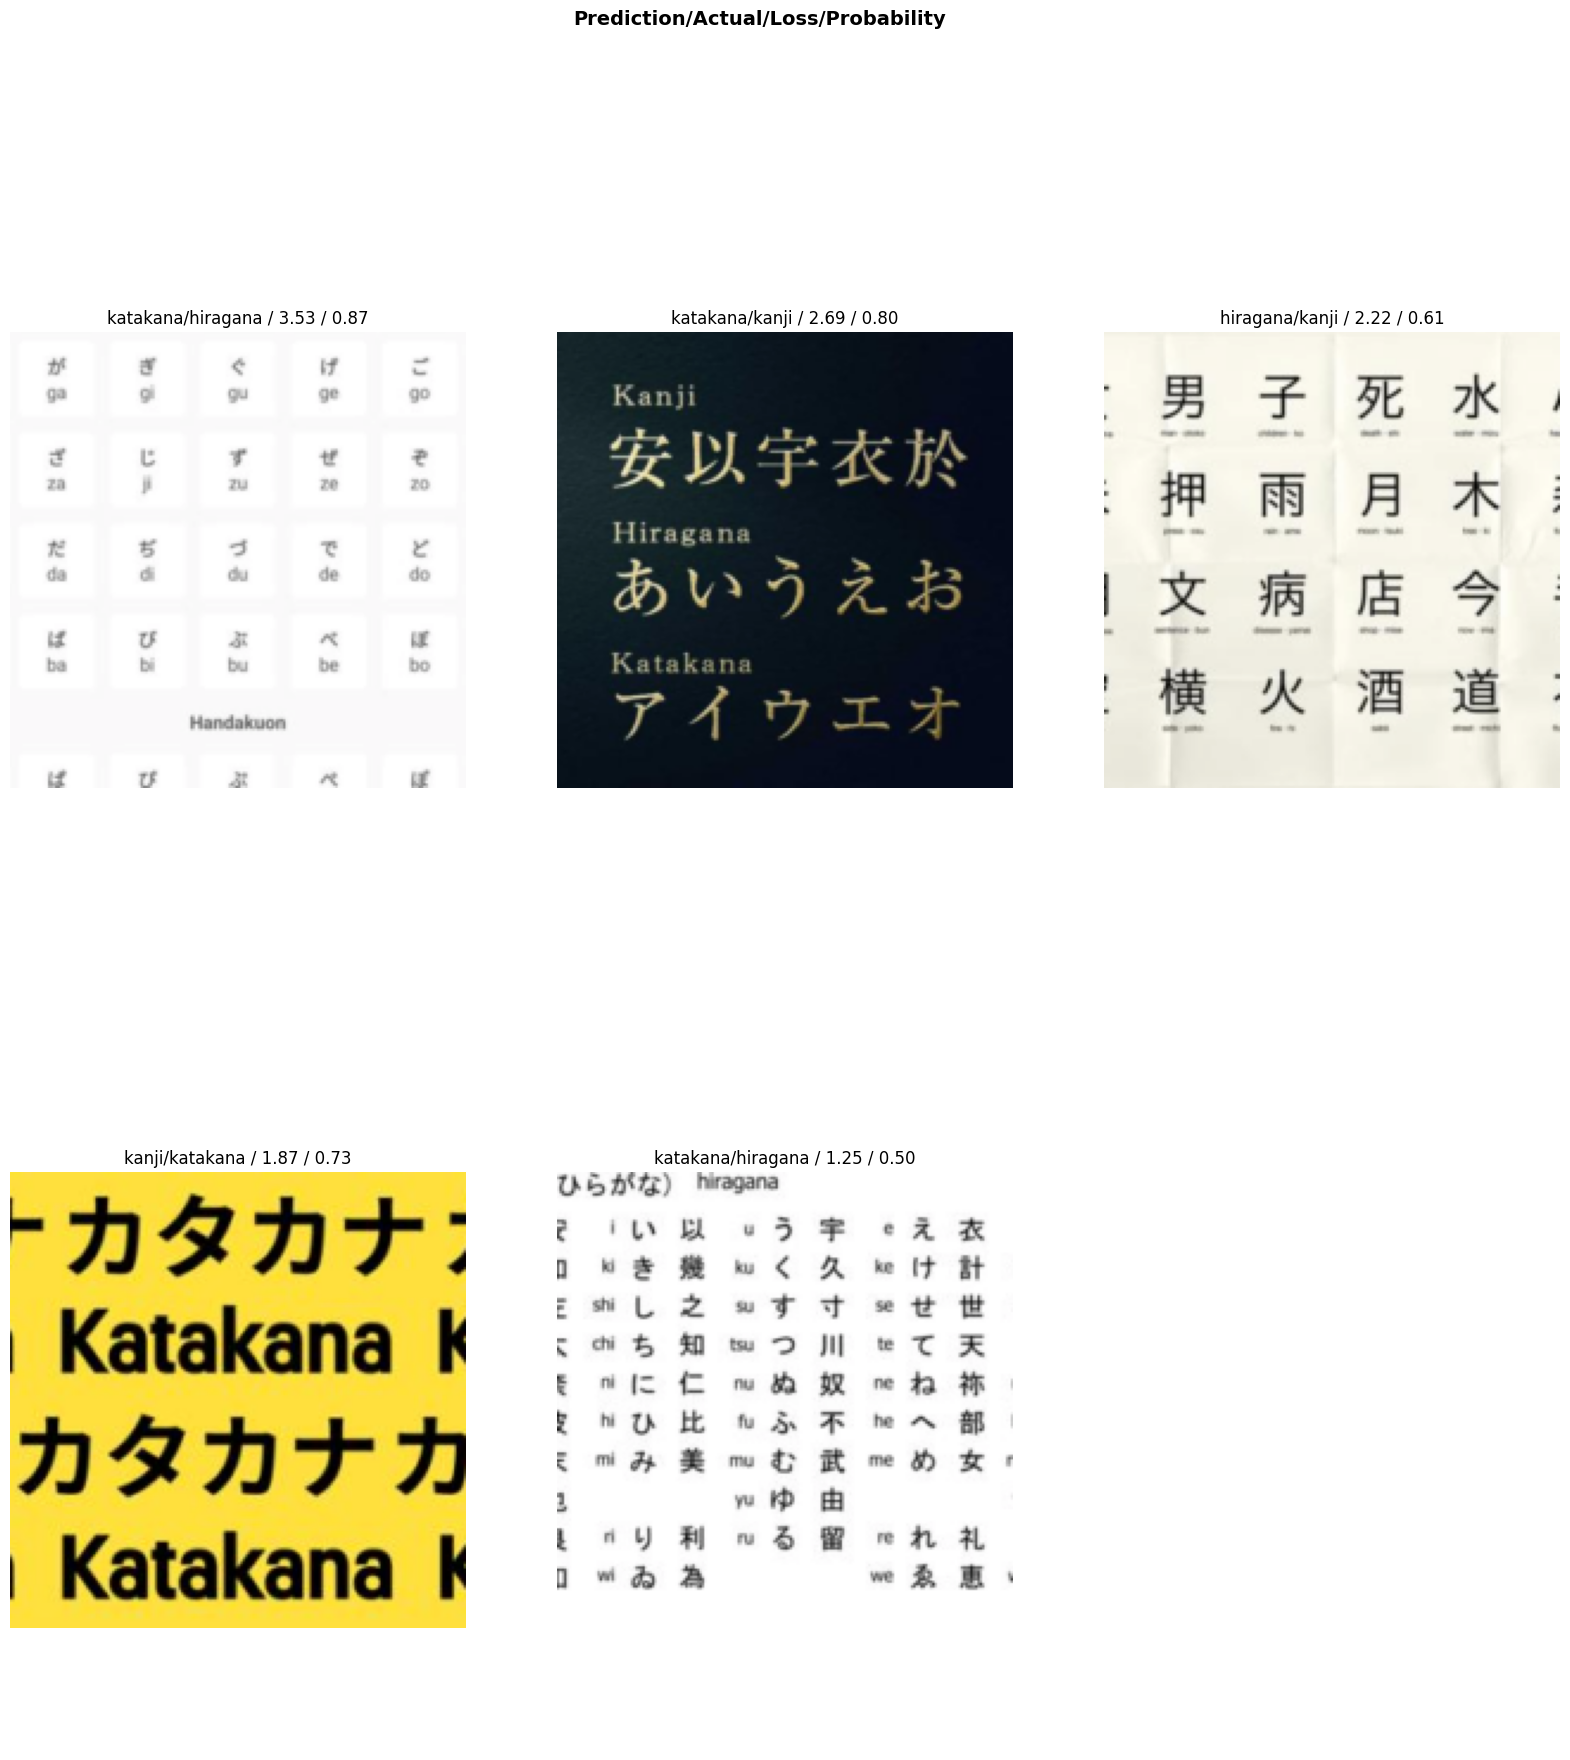

In [10]:
# Shows which images with the highest loss
# I.e.the images with the highest confidence it got wrong,
# Or ones with lowest confidence it got right 
interp.plot_top_losses(5, figsize = (20, 20))

In [ ]:
# *** this will only work in Jupyter notebooks
# Use to go through the images and remove or change any which make it harder for the model
# Need to run the next cell to save the changes

# Import library
from fastai.vision.widgets import ImageClassifierCleaner

# Run cleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [16]:
# After running this, redo the model
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

A method when not using jupyter notebook


Class hiragana - Top 5 losses:

File: dataset/hiragana/000002.jpg
Predicted: katakana, True: hiragana
Loss: 1.5161, Confidence: 0.0259, Reason: Incorrect prediction


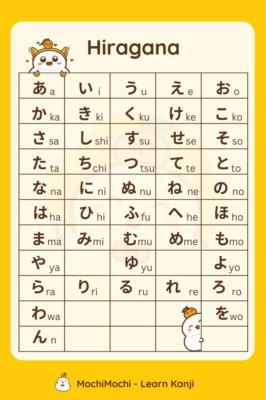

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/hiragana/000011.jpg
Predicted: katakana, True: hiragana
Loss: 1.4574, Confidence: 0.0283, Reason: Incorrect prediction


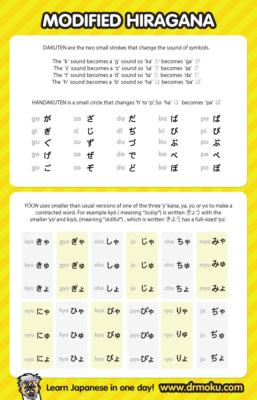

Action? [k]eep / [d]elete / [m]ove:  d


Deleted

File: dataset/hiragana/000016.jpg
Predicted: katakana, True: hiragana
Loss: 1.4350, Confidence: 0.0840, Reason: Incorrect prediction


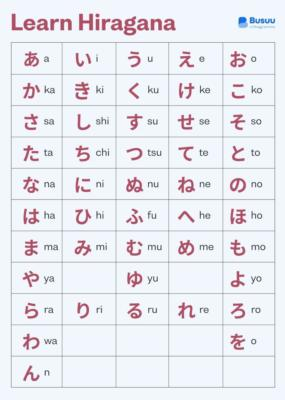

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/hiragana/000012.jpg
Predicted: katakana, True: hiragana
Loss: 1.1364, Confidence: 0.3173, Reason: Incorrect prediction


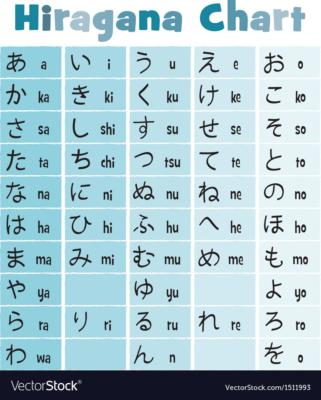

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/hiragana/000020.jpg
Predicted: katakana, True: hiragana
Loss: 0.9954, Confidence: 0.4613, Reason: Incorrect prediction


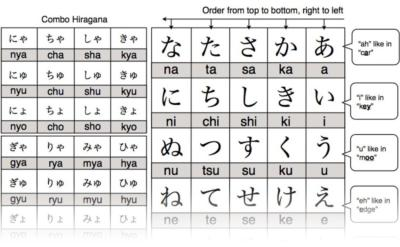

Action? [k]eep / [d]elete / [m]ove:  k


Kept

Class katakana - Top 5 losses:

File: dataset/katakana/000014.jpg
Predicted: hiragana, True: katakana
Loss: 1.4791, Confidence: 0.0521, Reason: Incorrect prediction


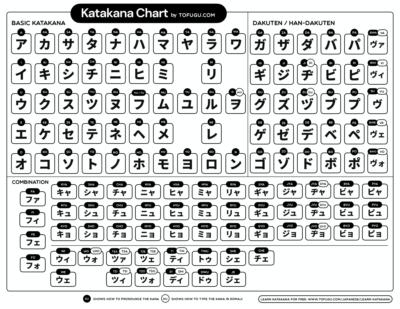

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/katakana/000013.jpg
Predicted: hiragana, True: katakana
Loss: 1.4243, Confidence: 0.0807, Reason: Incorrect prediction


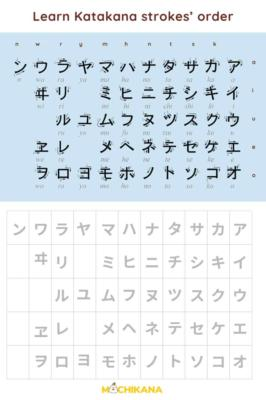

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/katakana/000032.jpg
Predicted: hiragana, True: katakana
Loss: 1.1054, Confidence: 0.3580, Reason: Incorrect prediction


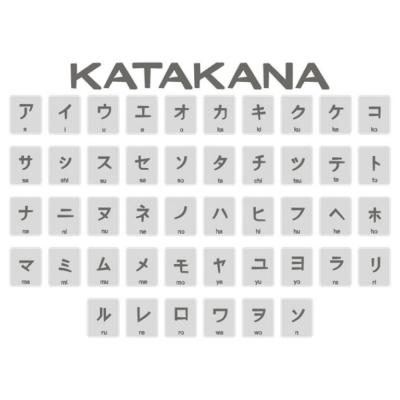

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/katakana/000010.jpg
Predicted: hiragana, True: katakana
Loss: 1.0372, Confidence: 0.4160, Reason: Incorrect prediction


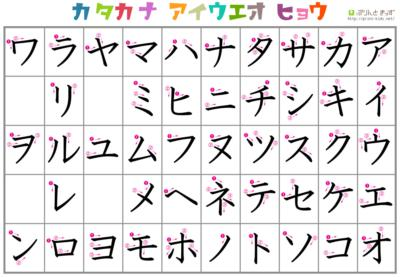

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/katakana/000027.jpg
Predicted: katakana, True: katakana
Loss: 0.9518, Confidence: 0.5034, Reason: Low confidence


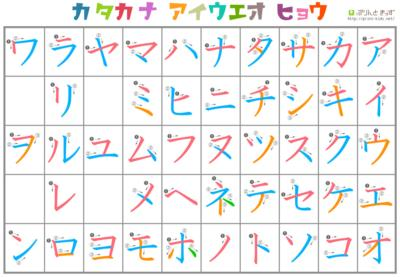

Action? [k]eep / [d]elete / [m]ove:  k


Kept

Class kanji - Top 5 losses:

File: dataset/kanji/000014.jpg
Predicted: katakana, True: kanji
Loss: 1.4821, Confidence: 0.0043, Reason: Incorrect prediction


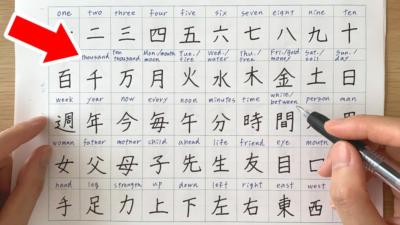

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/kanji/000028.jpg
Predicted: hiragana, True: kanji
Loss: 1.3880, Confidence: 0.0629, Reason: Incorrect prediction


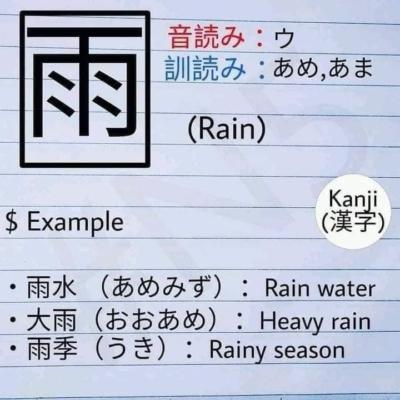

Action? [k]eep / [d]elete / [m]ove:  d


Deleted

File: dataset/kanji/000009.jpg
Predicted: katakana, True: kanji
Loss: 1.3802, Confidence: 0.0766, Reason: Incorrect prediction


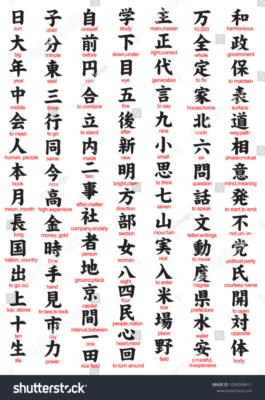

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/kanji/000012.jpg
Predicted: katakana, True: kanji
Loss: 1.3452, Confidence: 0.1278, Reason: Incorrect prediction


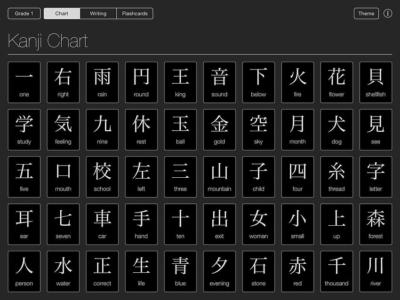

Action? [k]eep / [d]elete / [m]ove:  k


Kept

File: dataset/kanji/000022.jpg
Predicted: katakana, True: kanji
Loss: 1.3213, Confidence: 0.1417, Reason: Incorrect prediction


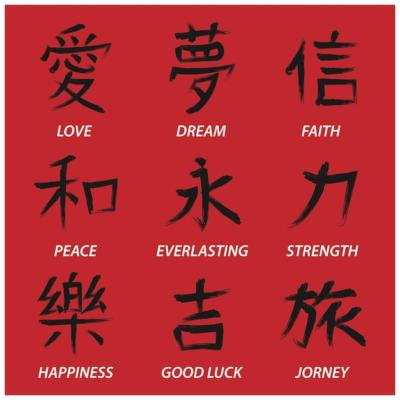

Action? [k]eep / [d]elete / [m]ove:  k


Kept


In [11]:
# Get predictions and targets
dl = learn.dls.train
preds, targs = learn.get_preds(dl=dl)
fnames = [str(f) for f in dl.items]

# Compute per-image loss
losses = F.cross_entropy(preds, targs, reduction='none')

# Organize by true class
from collections import defaultdict
class_losses = defaultdict(list)
for i, (f, t, p, l) in enumerate(zip(fnames, targs, preds.argmax(dim=1), losses)):
    class_losses[int(t)].append({'file': f, 'pred': int(p), 'loss': float(l), 'conf': float(preds[i][int(t)])})

# Interactive CLI loop
top_n = 5

for cls, items in class_losses.items():
    print(f"\nClass {dl.vocab[cls]} - Top {top_n} losses:")
    
    # Sort by loss descending
    items = sorted(items, key=lambda x: x['loss'], reverse=True)[:top_n]
    
    for item in items:
        f = item['file']
        pred = item['pred']
        loss = item['loss']
        conf = item['conf']
        
        # Determine reason for high loss
        reason = "Incorrect prediction" if pred != cls else "Low confidence"
        
        # Display info
        print(f"\nFile: {f}")
        print(f"Predicted: {dl.vocab[pred]}, True: {dl.vocab[cls]}")
        print(f"Loss: {loss:.4f}, Confidence: {conf:.4f}, Reason: {reason}")
        
        # Display image (works in Kaggle)
        display(PILImage.create(f))
        
        # User choice
        choice = input("Action? [k]eep / [d]elete / [m]ove: ").lower()
        if choice == 'd':
            os.remove(f)
            print("Deleted")
        elif choice == 'm':
            new_cat = input(f"Move to which class? {dl.vocab}: ")
            dest = path/new_cat
            dest.mkdir(exist_ok=True)
            shutil.move(f, dest/f.split('/')[-1])
            print(f"Moved to {new_cat}")
        else:
            print("Kept")

# Testing the Model

## Using search images

In [9]:
import random

# Pick a random image from the chosen data set
def choose_image(image_name, root):
    'User inputs one of the categories and an image will be chosen at random'
    category_path = root/image_name
    if not category_path.exists():
        print('ERROR: Category not trained in model')
        return None
    images = get_image_files(category_path)
    chosen_image = random.choice(images)
    return chosen_image

def test_image(img, model):
    'User inputs picture and the model predicts which category it fits in'
    category,pos,probs = model.predict(PILImage.create(img)) # string, _, list
    print(f'This is a: {category}')
    print(f"Probability it's a {category}: {probs[pos]:.4f}")

In [18]:
# Obtain new images to test the data
testing_root = Path('trainingset')
searches = ['bumble bee man']
for search in searches:
    search_images(search, num_images = 5, show_n = 0, root = testing_root, offset=100) # change offset if no. images changed before

Downloaded 5 'bumble bee man' images


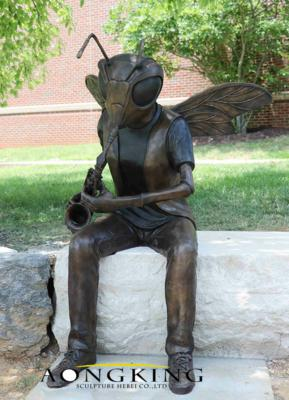

This is a: hornet
Probability it's a hornet: 0.8568


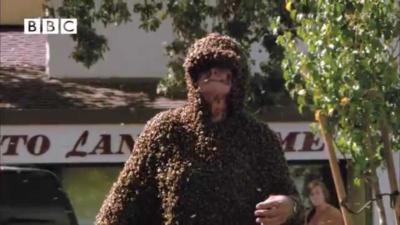

This is a: bee
Probability it's a bee: 0.9671


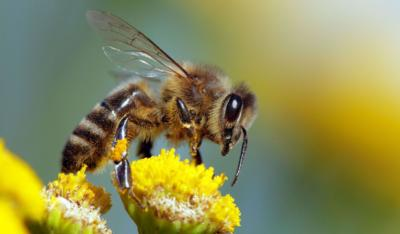

This is a: bee
Probability it's a bee: 0.9496


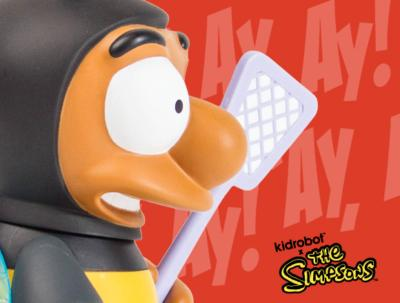

This is a: bee
Probability it's a bee: 0.9953


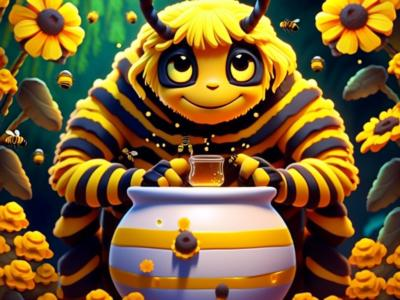

This is a: bee
Probability it's a bee: 0.9777


In [19]:
for img in get_image_files(testing_root/'bumble bee man'):
    display(PILImage.create(img))
    test_image(img, learn)

## Using own images 

In [ ]:
### For one image
# Adjust path depending on what you uploaded
img_path = Path("/kaggle/input/joscat/IMG-20251002-WA0030.jpg")
img = PILImage.create(img_path)
img.thumbnail((400, 300))
display(PILImage.create(img))
test_image(img, learn)

In [ ]:
### For a folder of images
# Path to your folder of images
test_folder = Path("/kaggle/input/catsss")  # adjust as needed

# Loop through all images
for img_path in test_folder.iterdir():
    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:  # skip non-image files
        # Optionally resize the image
        img = PILImage.create(img_path)  # fastai PILImage
        img.thumbnail((400, 300))
        display(PILImage.create(img))
        test_image(img, learn)